In [2]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2

# Builtin packages
from importlib import reload
import logging
import os
from pathlib import Path
import sys
import warnings

# standard secondary packages
import astropy as ap
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import tqdm.notebook as tqdm

# development packages
import kalepy as kale
import kalepy.utils
import kalepy.plot

# --- Holodeck ----
import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

# Load log and set logging level
log = holo.log
log.setLevel(logging.INFO)

# Mbh - Mbulge Relations

In [ ]:
mbulge = np.logspace(4, 12, 100)
generic = holo.relations.MMBulge_Standard(mamp=1e8*MSOL, mplaw=1.0)
MM2013 = holo.relations.MMBulge_MM2013()
KH2013 = holo.relations.MMBulge_KH2013()

fig, ax = plot.figax()

xx = mbulge
yy = MM2013.mbh_from_mbulge(mbulge*MSOL, scatter=False)/MSOL
hh, = ax.plot(xx, yy, label='MM2013 (bulge)')

yy = MM2013.mbh_from_mstar(mbulge*MSOL, scatter=False)/MSOL
ax.plot(xx, yy, label='MM2013 (stellar)', color=hh.get_color(), ls='--')

yy = KH2013.mbh_from_mbulge(mbulge*MSOL, scatter=False)/MSOL
ax.plot(xx, yy, label='KH2013')

plt.legend()
plt.show()

In [ ]:
MM2013 = holo.relations.MMBulge_MM2013()
KH2013 = holo.relations.MMBulge_KH2013()

fig, ax = plot.figax()

NUM = 1e2

xx = 10.0**np.random.uniform(*np.log10([mbulge.min(), mbulge.max()]), int(NUM))
yy = MM2013.mbh_from_mbulge(xx*MSOL, scatter=True)/MSOL
ax.scatter(xx, yy, label='MM2013', alpha=0.4)

xx = 10.0**np.random.uniform(*np.log10([mbulge.min(), mbulge.max()]), int(NUM))
yy = KH2013.mbh_from_mbulge(xx*MSOL, scatter=True)/MSOL
ax.scatter(xx, yy, label='KH2013', alpha=0.4)

plt.legend()
plt.show()

# Stellar-Mass vs. Halo-Mass Relation

In [ ]:
mhalo = np.logspace(10, 15, 100)

## Guo et al. 2010

In [ ]:
guo = holo.relations.Guo_2010()
mstar = guo.stellar_mass(mhalo * MSOL) / MSOL

fig, ax = plt.subplots(figsize=[10, 6])
ax.set(xscale='log', yscale='log')
ax.grid(True)

ax.plot(mhalo, mstar)

plt.plot

<b>plot from the paper:</b>
<div>
<img src="attachment:Screen%20Shot%202021-08-19%20at%2012.16.41%20PM.png" width="50%"/>
</div>

## Behroozi et al. 2013

In [ ]:
rooz = holo.relations.Behroozi_2013()

In [ ]:
NOTE = """This doesn't match the paper plot well (Behroozi+2013, Fig.7, left-panel)
but I think that's because what they plot is the mean, marginalized over parameter uncertainties,
while this plot is using the mean values of each parameter.  Those aren't the same thing!
"""
print(NOTE)

zlist = [0.1,] + np.arange(1, 9).tolist()
colors = ['k', 'r', 'orange', 'yellow', 'green', 'cyan', 'dodgerblue', 'navy', 'violet']
print(zlist)
limits = [
    [1e10, 1e15],   # k
    [8e10, 6e14],   # r
    [2e11, 1.5e14], # ora
    [3e11, 5e13],   # yel
    [3e11, 3e13],   # grn
    [2e11, 8e12],   # cyan
    [1.5e11, 4e12], # light blue
    [1e10, 4e11],   # dark blue
    [1.5e10, 8e10]  # violet
]


fig, ax = plt.subplots(figsize=[10, 8])
ax.set(xscale='log', yscale='log')
ax.grid(True)

for zz, cc, lim in zip(zlist, colors, limits):
    mstar = rooz.stellar_mass(mhalo * MSOL, zz) / MSOL
    idx = (lim[0] < mhalo) & (mhalo < lim[1])
    # idx = slice(None)
    yy = mstar
    # yy = mstar / mhalo
    ax.plot(mhalo[idx], yy[idx], color=cc, lw=2.0)
    
plt.show()


<b>plot from the paper (Behroozi+2013, Fig.7):</b>
<div>
<img src="attachment:Screen%20Shot%202021-08-19%20at%2012.21.39%20PM.png" width="100%"/>
</div>

In [ ]:
redz = np.linspace(0.0, 6.0, 40)
 
mstar = rooz.stellar_mass(mhalo[:, np.newaxis] * MSOL, redz[np.newaxis, :]) / MSOL

### Test/Check interpolation from mstar ==> mhalo

In [ ]:
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

rooz = holo.relations.Behroozi_2013()

# breaker()

mhalo = rooz._mhalo_grid
redz = rooz._redz_grid
mstar = rooz._mstar

NUM = 30

fig, ax = plt.subplots(figsize=[10, 8])
pcm = ax.pcolormesh(np.log10(mhalo/MSOL), redz, np.log10(mstar/MSOL).T)
cbar = plt.colorbar(pcm, ax=ax)

ss = MSOL * 10.0 ** np.random.uniform(5, 13, NUM)
zz = np.random.uniform(0.0, 9.0, NUM)

hh = rooz.halo_mass(ss, zz)

ss = np.log10(ss/MSOL)
hh = np.log10(hh/MSOL)
cc = cbar.cmap(cbar.norm(ss))

ax.scatter(hh, zz, c=cc, edgecolor='r', lw=1.0, s=100)


plt.show()

In [ ]:
fig, axes = plot.figax(figsize=[12, 15], scale='lin', nrows=2, sharex=True, sharey=True)

aa = rooz._aa
bb = rooz._bb
cc = rooz._cc
print(utils.stats(cc), cc.shape)

norm = mpl.colors.Normalize(cc.min(), cc.max())
smap = mpl.cm.ScalarMappable(norm, cmap='viridis')
colors = smap.to_rgba(cc)
ax = axes[0]
ax.scatter(aa, bb, c=colors)


ax = axes[1]
xx = np.log10(rooz._mstar_grid/MSOL)
yy = rooz._redz_grid
ax.pcolormesh(xx, yy, rooz._grid.T, norm=smap.norm, cmap=smap.cmap)

zz = [5.01]
mm = [11.5]
hh = rooz._mhalo_from_mstar_redz(np.atleast_2d([mm, zz]).T)[0]
print(f"hh={hh:.4e}")
ax.scatter(mm, zz, c=smap.to_rgba(hh), edgecolor='r', lw=2.0)

plt.show()

## Check reversing relation for consistency

In [ ]:
NUM = 1000
behr = holo.relations.Behroozi_2013()

# mbh = np.random.uniform(5, 11, NUM)
# mbh = np.linspace(5, 11, NUM)
mbh = np.linspace(5, 10, NUM)
mbh = MSOL * (10.0 ** mbh)
# redz = np.random.uniform(0.0, 6.0, NUM)
redz = np.zeros_like(mbh)

mmb = holo.relations.get_mmbulge_relation()
mstar = mmb.mstar_from_mbh(mbh, scatter=False)
print(f"{mstar.max()/MSOL=:.4e}")

mhalo = behr.halo_mass(mstar, redz)
print(f"{mhalo.max()/MSOL=:.4e}")

mstar_check = behr.stellar_mass(mhalo, redz)
mhalo_check = behr.halo_mass(mstar, redz)
print(f"{mstar_check.max()/MSOL=:.4e}")
print(f"{mhalo_check.max()/MSOL=:.4e}")

print(f"mstar  input: {holo.utils.stats(mstar/MSOL)}")
print(f"mstar output: {holo.utils.stats(mstar_check/MSOL)}")
# bads = ~np.isclose(mstar, mstar_check, rtol=0.1)
# if np.any(bads):
#     print(f"bad mstar input  : {mstar[bads]/MSOL}")
#     print(f"bad mstar output : {mstar_check[bads]/MSOL}")
# assert not np.any(bads)

print(f"mhalo  input: {holo.utils.stats(mhalo/MSOL)}")
print(f"mhalo output: {holo.utils.stats(mhalo_check/MSOL)}")
# bads = ~np.isclose(mhalo, mhalo_check, rtol=0.1)
# if np.any(bads):
#     print(f"bad mhalo input  : {mhalo[bads]/MSOL}")
#     print(f"bad mhalo output : {mhalo_check[bads]/MSOL}")
# assert not np.any(bads)

In [ ]:
fig, ax = plot.figax()
ax.scatter(mhalo/MSOL, mstar/MSOL, color='r', marker='.', alpha=0.5)
ax.scatter(mhalo/MSOL, mstar_check/MSOL, color='b', marker='x', alpha=0.2)

plt.show()

# Density Profiles

## NFW

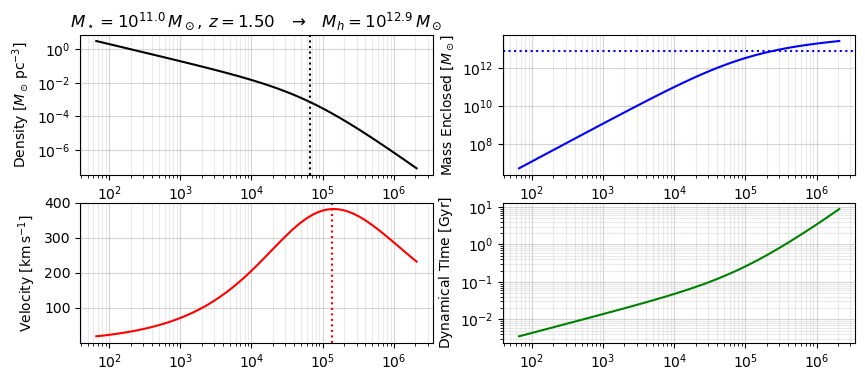

In [3]:
mstar = 1e11 * MSOL
zz = 1.5

DENS_UNITS = MSOL / PC ** 3

nfw = holo.relations.NFW
smhm = holo.relations.Behroozi_2013()
mhalo = smhm.halo_mass(mstar, zz)

fig, axes = plot.figax(figsize=[10, 4], ncols=2, nrows=2)
axes = axes.flatten()

# ---- Density
ax_dens = axes[0]
mstar_str = f"10^{{{np.log10(mstar/MSOL):.1f}}} \, M_\odot"
mhalo_str = f"10^{{{np.log10(mhalo/MSOL):.1f}}} \, M_\odot"
ax_dens.set_title(fr"$M_\star = {mstar_str}, \, z = {zz:.2f} \;\;\; \rightarrow \;\;\; M_h = {mhalo_str}$")

ax_dens.set(xlabel='Radius $[\mathrm{pc}]$', ylabel='Density $[M_\odot \mathrm{\, pc}^{-3}]$')
ax_dens.grid(True)

rscale = nfw.radius_scale(mhalo, zz)

rads = np.logspace(-3, 1.5, 100) * rscale
dens = nfw.density(rads, mhalo, zz)

hh, = ax_dens.plot(rads/PC, dens/DENS_UNITS, color='k')
ax_dens.axvline(rscale/PC, color='k', ls=':')


# ---- Mass 
col = 'b'
# ax_mass = ax_dens.twinx()
ax_mass = axes[1]
ax_mass.set(yscale='log', ylabel='Mass Enclosed $[M_\odot]$')
# plot.set_axis_color(ax_mass, color=col, side='right')

mass = nfw.mass(rads, mhalo, zz)
ax_mass.plot(rads/PC, mass/MSOL, ls='-', color=col)
ax_mass.axhline(mhalo/MSOL, ls=':', color=col)


# ---- Velocity
col = 'r'
# ax_velo = ax_dens.twinx()
ax_velo = axes[2]
VELS_UNITS = 1e5
ax_velo.set(yscale='linear', ylabel='Velocity $[\mathrm{km \, s}^{-1}]$')
# plot.set_axis_color(ax_velo, color=col, side='right')
# plot.set_axis_pos(ax_velo, 'y', pos=1.1, side='right')

velo = nfw.velocity_circular(rads, mhalo, zz)
ax_velo.plot(rads/PC, velo/VELS_UNITS, color=col, ls='-')
idx = np.argmax(velo)
vmax_rad = rads[idx]
ax_velo.axvline(vmax_rad/PC, ls=':', color=col)

# ---- Dynamical Time
col = 'g'
# ax_time = ax_dens.twinx()
ax_time = axes[3]
TIME_UNITS = GYR
ax_time.set(yscale='log', ylabel='Dynamical TIme $[\mathrm{Gyr}]$')
# plot.set_axis_color(ax, color=col, side='right')
# plot.set_axis_pos(ax, 'y', pos=1.2, side='right')

tdyn = nfw.time_dynamical(rads, mhalo, zz)
ax_time.plot(rads/PC, tdyn/TIME_UNITS, color=col, ls='-')
# idx = np.argmax(velo)
# vmax_rad = rads[idx]
# ax_velo.axvline(vmax_rad/PC, ls=':', color=col)

# ax.legend()
plt.show()
    